# Saez (2001) Replication

In [1]:
# Load libraries
using Parameters
using CSV
using DataFrames
using Plots
using Trapz
using NumericalIntegration
using SpecialFunctions

In [2]:
# (Some imports / temporary)
# using Pkg
# Pkg.add("SpecialFunctions")

### Procedure

This solution of the Mirrlees model is based on the following parametrization.

We use the Type I utility function

$$u = \log\left(c - \frac{l^{1+k}}{1+k}\right) $$.

Let $c = z(1-\tau) + R$, where $\tau$ is the marginal tax rate and $R$ is virtual/non-labor income. Income is dependent on individual ability, $z = nl$, where $n$ is ability and $l$ is labor. Virtual income is also dependent on ability, $R = nl - T(nl) - nl(1-T')$. The distribution of skills is $F(n)$ with density $f(n)$ and support $[0, \infty)$.

The government does not observe ability sets taxes as a function of earnings $T(z)$, so net-of-tax consumption of $c = z-T(z)$. The government maximizes the social welfare function $W = \int_0^\infty G(u_n)f(n)dn$, where $G(.)$ is increasing and concave. Redistribution takes place through a guaranteed income level $-T(0)$. Here, we use $G(u) = log(u)$.

This utility function has no income effects, so the compensated and uncompensated elasticities are the same. The elasticity of income to the net-of-tax rate, $\frac{1-\tau}{z} \frac{\partial z}{\partial(1-\tau)}$ is $1/k$.

### Replicate opttax.m

Routine to solve the Mirrlees model.

We set the parameters according to the opttax.m file provided.

In [3]:
# Set some parameters
@with_kw struct params
    γ ::Int64            # SWF inequality aversion parameter
    k ::Int64            # Parametrizes elasticity ε
    e ::Float64 = 1/k    # Elasticity ε = 1/k
    a ::Int64            # Pareto parameter for upper income distribution
    R ::Int64            # Exogenous per-person revenue requirement
end;

In [4]:
pars = params(γ=1, k=4, a=2, R=4000)

params
  γ: Int64 1
  k: Int64 4
  e: Float64 0.25
  a: Int64 2
  R: Int64 4000


#### Data and income distribution manipulation

In [5]:
# Read in the data
simu = DataFrame(CSV.File("data/simu.csv", header = false));
# Columns: [Lower z, weighted pop, mean(z), marg tax rate]
rename!(simu, [:lz0, :pop, :z0, :τ0]);

In [6]:
# Manipulate the data
# Normalize population size to 1
nSimu = size(simu)[1];
simu.pop = simu.pop / sum(simu.pop);

# Pareto distribution of income above lower z0 = 200,000
simu_top = simu[simu.lz0 .< 200000,:]; # Same as aux in Saez
T = size(simu_top)[1];
p_top = sum(simu.pop[size(simu_top)[1]+1:nSimu]); # Population of top

# Compute the distribution of households below z0=200,000
fn = simu_top.pop;
Fn = zeros(T);
Fn[1] = fn[1];
for i in 2:T
    Fn[i] = Fn[i-1] + fn[i];
end

Smoothing out other variables.
(Note: Have some questions on this part)

In [7]:
# Smooth out the other variables
z0 = simu_top.z0; # Mean income
τ0 = simu_top.τ0; # Marginal tax rate
τ0 = 0.41 * ones(T); # Why?
τ_new = copy(τ0);
τ_old = copy(τ0);

for j in 1:1000
    for i in 2:T-1
        τ_new[i] = τ_old[i-1]*0.3 + τ_old[i]*0.4 + τ_old[i+1]*0.3 # Why?
    end
    τ_old = copy(τ_new);
end;

τ0 = τ_new;
τ_max = τ0[T];

n = z0 ./ (1 .- τ0).^pars.e; # What is this?

fn = diff(Fn) ./ diff(n);
push!(fn, fn[T-1]);

fnnew = copy(fn);
fnold = copy(fn);
for j in 1:3000
    for i in 2:T-1
        fnnew[i] = fnold[i-1]*0.3 + fnold[i]*0.4 + fnold[i+1]*0.3
    end
    fnold = copy(fnnew)
end;

fn = fnnew;
fn = ((1-p_top)/trapz(n, fn)) * fn;


In [8]:
# Generate skills at the top of the distribution
nmin = simu.z0[T]/(1-τ_max)^pars.e;
nmax = 10^7;
ntop = exp.(collect(range(log(nmin), log(nmax), 1000)));
num = size(n)[1];

# Parameters at the top of the distribution
τ_top = τ_max * ones(1000); # Tax rate
# PDF and CDF of skills (review)
fntop = p_top*pars.a*nmin^pars.a ./ (ntop.^(1+pars.a));
Fntop = 1 .- p_top*(nmin^pars.a) ./ (ntop .^ pars.a);


In [9]:
# Join the lower and upper distributions
popfirst!(ntop);
popfirst!(fntop);
popfirst!(Fntop);
popfirst!(τ_top);

n = [n; ntop];
fn = [fn; fntop];
τ0 = [τ0; τ_top];
z0 = n.*(1 .- τ0).^pars.e;

#### Iteration routine

In [12]:
# Iterate through the budget constraint
num = size(n)[1]
T0 = -0.2
dTax = 10000
outer_iter = 0
τ_final = 0.2 * ones(size(n))
while abs(dTax) > 1
    outer_iter += 1
    T0 = T0 - dTax
    λ0 = 0
    λ = 1
    SWF = 1
    SWF0 = 0
    Tax = 1
    Tax0 = 0
    τ = 0.2 * ones(size(n))
    τ_new = τ
    
    while abs(λ0 - λ) > 0.0001 ||
     abs(SWF0 - SWF) > 0.0001 ||
     abs(Tax0 - Tax) > 0.0001
        τ = τ_new        
        
        u = -T0 .+ cumul_integrate(n, ((1 .- τ).^(1+1/pars.k))/(1+1/pars.k))
        λ0 = λ
        λ = trapz(n, (u.^-pars.γ).*fn)
        #println(λ)
        
        intaux = cumul_integrate(n, (u.^-pars.γ/λ .- 1).*fn)
        
        τ_new = pars.k * intaux ./ (n .* fn)
        τ_new = τ_new ./ (1 .+ τ_new)
        z = n.*(1 .- τ_new).^(1/pars.k)
        c = u .+ n.*((z./n).^(pars.k+1))/(pars.k+1)
        T = z-c
        g = u.^-pars.γ/λ
        
        Tax0 = Tax
        SWF0 = SWF
        Tax = trapz(n, T.*fn)
        SWF = trapz(n, digamma.(u).*fn)
        
        #println(SWF)
        
    end
    #naux = n[1]
    #τ_aux = τ_new[1]
    τ_final = copy(τ_new)
    dTax=Tax-pars.R
end

4.7494942590765704e-5
10.054285036319905
6.733218896536548e-5
9.657197069303106
6.04947820514974e-5
9.771989743204328
6.270700849731488e-5
9.73480298729113
6.210812515803222e-5
9.744402452300795
6.224559493590742e-5
9.742287877235121
6.222245697614054e-5
9.742608844823163
6.222336626116543e-5
9.742612933563152
6.222478531517151e-5
9.742584486158844
6.222396602074056e-5
9.742599077715527
6.222427956695026e-5
9.74259375431131
6.222418225696145e-5
9.742595350406852
6.222420758633256e-5
9.742594949794665
6.222420228341499e-5
9.742595028977238
6.22242029861253e-5
9.742595020325822
5.188106052608136e-5
9.979130191512834
7.721912638025821e-5
9.527887292771672
6.849698183634029e-5
9.65552723088744
7.127426169595749e-5
9.614866944058516
7.055415732171726e-5
9.624813440484969
7.070364759180419e-5
9.622876860917414
7.068597411102222e-5
9.623049700544367
7.068261732069422e-5
9.623122453650122
7.0685889978243e-5
9.623069409710384
7.068445028316938e-5
9.623091179110292
7.06849306335927e-5
9.62308421

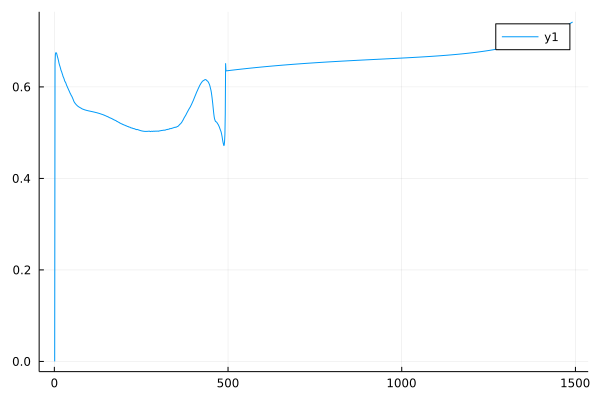

In [15]:
plot(τ_final)